# Chapter 7 Applied Exercises

## Problem 6

### In this exercise, you will further analyze the Wage data set considered throughout this chapter.

In [45]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

In [46]:
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

#### Part (a)

Perform polynomial regression to predict wage using age. Use cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to
the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data.

In [47]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

In [48]:
import sklearn.model_selection as skm

In [49]:
poly_age = MS([poly('age', degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [50]:
from sklearn.model_selection import cross_validate, KFold

In [51]:
from ISLP.models import sklearn_sm

In [52]:
cv_error = np.zeros(6)
H = np.array(age)
M = sklearn_sm(sm.OLS)
#Let's introduce splits. We choose 5-folds cross validation for this example
cv = KFold(n_splits=5,shuffle=True,random_state=0) # The argument shuffle allows samples to overlap
for i, d in enumerate(range(1,7)):
    Xcross = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,Xcross,y,cv=cv)
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([1675.97797787, 1600.6843786 , 1597.00855538, 1596.20945876,
       1598.21530779, 1597.23739361])

4th Degree Polynomial

In [53]:
model = sm.OLS(y,np.power.outer(H, np.arange(5))).fit()

In [54]:
Xcross = np.power.outer(H, np.arange(5))

In [55]:
# newX = poly_age.transform(age_df)
preds = model.get_prediction(Xcross)
#bands = preds.conf_int(alpha=0.05)

In [56]:
preds.predicted_mean

array([ 51.93145032,  84.47675567, 119.32598488, ...,  95.44973384,
        95.44973384, 118.6326942 ])

Text(0, 0.5, 'Wage')

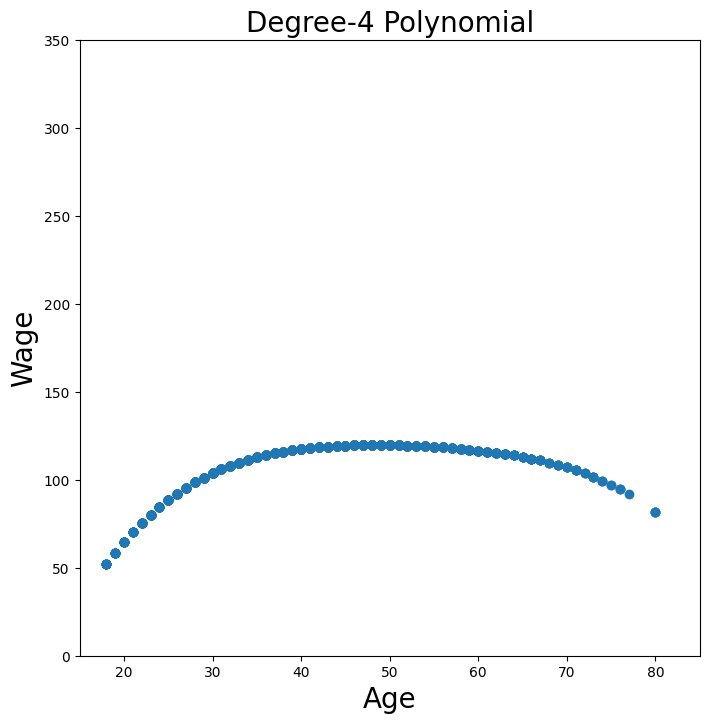

In [57]:
fig, ax = subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(age, preds.predicted_mean)
ax.set_title('Degree-4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylim([0,350])
ax.set_xlim([15,85])
ax.set_ylabel('Wage', fontsize=20)

Decided on the same degree as with ANOVA.

#### Part (b)

Fit a step function to predict wage using age, and perform cross-validation to choose the optimal number of cuts. Make a plot of the fit obtained.

In [58]:
cut_age = pd.qcut(age, 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


In [59]:
cv_error = np.zeros(30)
H = np.array(age)
M = sklearn_sm(sm.OLS)
#Let's introduce splits. We choose 5-folds cross validation for this example
cv = KFold(n_splits=5,shuffle=True,random_state=0) # The argument shuffle allows samples to overlap
for d in range(0,30):
    Xcross = pd.qcut(age, d+1)
    M_CV = cross_validate(M,pd.get_dummies(Xcross),y,cv=cv)
    cv_error[d] = np.mean(M_CV['test_score'])
cv_error

array([1742.94424898, 1703.98624771, 1660.21747041, 1643.54893817,
       1641.65415209, 1636.90408532, 1627.35473711, 1624.53060805,
       1625.31470466, 1619.42520284, 1622.99428956, 1622.98944769,
       1616.50042257, 1613.99483953, 1617.08432164, 1617.62667623,
       1620.03577132, 1618.02476215, 1617.60926168, 1618.28838019,
       1618.78656934, 1618.66520555, 1615.71065115, 1615.08454302,
       1623.61393177, 1622.5769718 , 1617.18053982, 1619.97063009,
       1612.53017386, 1613.04645163])

Choose 10 cuts for the best CV error. The CV error stops decreasing significantly after 10 cuts.

In [60]:
cut_age = pd.qcut(age, 10)
tencuts = summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())
tencuts

,coef,std err,t,P>|t|
"(17.999, 27.0]",82.2511,2.205,37.297,0.0
"(27.0, 32.0]",102.3635,2.202,46.487,0.0
"(32.0, 35.0]",110.0889,2.601,42.330,0.0
"(35.0, 39.0]",119.1562,2.261,52.710,0.0
"(39.0, 42.0]",116.7891,2.344,49.826,0.0
"(42.0, 46.0]",121.6993,2.097,58.030,0.0
"(46.0, 49.0]",117.8501,2.424,48.621,0.0
"(49.0, 53.0]",115.7022,2.286,50.610,0.0
"(53.0, 58.0]",117.8944,2.340,50.383,0.0
"(58.0, 80.0]",115.7284,2.543,45.516,0.0


In [73]:
xr = np.zeros(10)
for i in range(0,10):
    string1=tencuts.index[i]
    substring = string1[-5:]
    substring = substring[:-1]
    xr[i] = float(substring)
xr

array([27., 32., 35., 39., 42., 46., 49., 53., 58., 80.])

In [75]:
xl = np.zeros(11)
for i in range(0,10):
    string1=tencuts.index[i]
    substring = string1[:-7]
    substring = substring[1:]
    xl[i] = float(substring)
xl[10]=xr[9]

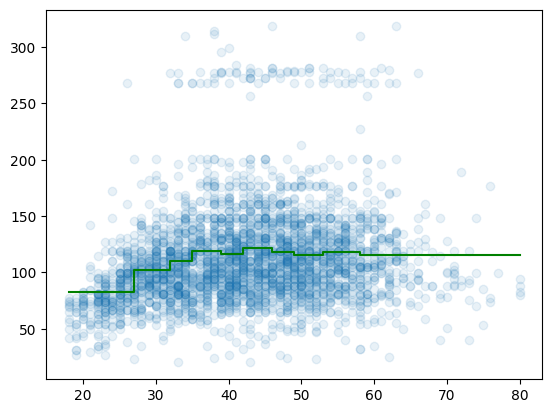

In [77]:
import matplotlib.pyplot as plt
import numpy as np
  
xr = np.zeros(10)
for i in range(0,10):
    string1=tencuts.index[i]
    substring = string1[-5:]
    substring = substring[:-1]
    xr[i] = float(substring)
y_step = np.zeros(11)
for i in range(0,10):
    y_step[i]=tencuts.coef[i]
y_step[10]=tencuts.coef[9]
  
plt.step(xl, y_step, 'g', where='post')
plt.scatter(age,y,alpha=0.1)
plt.show()

## Problem 7

The Wage data set contains a number of other features not explored in this chapter, such as marital status (maritl), job class (jobclass), and others. Explore the relationships between some of these other predictors and wage, and use non-linear fitting techniques in order to fit flexible models to the data. Create plots of the results obtained, and write a summary of your findings.

## Problem 8

Fit some of the non-linear models investigated in this chapter to the Auto data set. Is there evidence for non-linear relationships in this data set? Create some informative plots to justify your answer.

## Problem 9

This question uses the variables dis (the weighted mean of distances to five Boston employment centers) andnox (nitrogen oxides concentration in parts per 10 million) from the Boston data. We will treat dis as the predictor and nox as the response.

#### Part (a)

Use the poly() function from the ISLP.models module to fit a cubic polynomial regression to predict nox using dis. Report the regression output, and plot the resulting data and polynomial fits.

#### Part (b)

Plot the polynomial fits for a range of different polynomial degrees (say, from 1 to 10), and report the associated residual sum of squares.

#### Part (c)

Perform cross-validation or another approach to select the optimal degree for the polynomial, and explain your results.

#### Part (d)

Use the bs() function from the ISLP.models module to fit a regression spline to predict nox using dis. Report the output for the fit using four degrees of freedom. How did you choose the knots? Plot the resulting fit.

#### Part (e)

Now fit a regression spline for a range of degrees of freedom, and plot the resulting fits and report the resulting RSS. Describe the results obtained.

#### Part (f)

Perform cross-validation or another approach in order to select the best degrees of freedom for a regression spline on this data. Describe your results.

## Problem 10

This question relates to the College data set.

#### Part (a)

Split the data into a training set and a test set. Using out-of-state tuition as the response and the other variables as the predictors, perform forward stepwise selection on the training set in order to identify a satisfactory model that uses just a subset of the predictors.

#### Part (b)

Fit a GAM on the training data, using out-of-state tuition as the response and the features selected in the previous step as the predictors. Plot the results, and explain your findings.

#### Part (c)

Evaluate the model obtained on the test set, and explain the results obtained.

#### Part (d)

For which variables, if any, is there evidence of a non-linear relationship with the response?

## Problem 11

### In Section 7.7, it was mentioned that GAMs are generally fit using a backfitting approach. 
### The idea behind backfitting is actually quite simple. We will now explore backfitting in the context of multiple linear regression.

Suppose that we would like to perform multiple linear regression, but we do not have software to do so. Instead, we only have software to perform simple linear regression. Therefore, we take the following iterative approach: we repeatedly hold all but one coefficient estimate fixed at its current value, and update only that coefficient estimate using a simple linear regression. The process is continued until convergence—that is, until the coefficient estimates stop changing.

We now try this out on a toy example.

#### Part (a)

Generate a response $Y$ and two predictors $X_1$ and $X_2$, with
$n = 100$.

#### Part (b)

Write a function simple_reg() that takes two arguments outcome and feature, fits a simple linear regression model with this outcome and feature, and returns the estimated intercept and slope.

#### Part (c)

Initialize beta1 to take on a value of your choice. It does not
matter what value you choose.

#### Part (d)

Keeping beta1 fixed, use your function simple_reg() to fit the model:
$$Y− beta1· X_1 = β_0 + β_2X_2 + ϵ.$$
Store the resulting values as beta0 and beta2.

#### Part (e)

Keeping beta2 fixed, fit the model
$$Y− beta2· X_2 = β_0 + β_1X_1 + ϵ.$$
Store the result as beta0 and beta1 (overwriting their previous
values).

#### Part(f)

Write a for loop to repeat (c) and (d) 1,000 times. Report the
estimates of beta0, beta1, and beta2 at each iteration of the for
loop. Create a plot in which each of these values is displayed,
with beta0, beta1, and beta2.

#### Part (g)

Compare your answer in (e) to the results of simply performing multiple linear regression to predict $Y$ using $X_1$ and $X_2$.
Use axline() method to overlay those multiple linear regression coefficient estimates on the plot obtained in (e).

#### Part (h)

On this data set, how many backfitting iterations were required in order to obtain a “good” approximation to the multiple regression coefficient estimates?

## Problem 12

This problem is a continuation of the previous exercise. In a toy
example with p = 100, show that one can approximate the multiple
linear regression coefficient estimates by repeatedly performing simple
linear regression in a backfitting procedure. How many backfitting
iterations are required in order to obtain a “good” approximation to
the multiple regression coefficient estimates? Create a plot to justify
your answer.